<a href="https://colab.research.google.com/github/Bienbaz/Bienbaz/blob/main/vrp_pulp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install pulp matplotlib

Status: Optimal
Total distance (objective): 28.18
Selected arcs: [(0, 1), (0, 3), (1, 0), (2, 4), (3, 5), (4, 0), (5, 2)]

Routes found:
 Vehicle 1: [0, 1, 0]
 Vehicle 2: [0, 3, 5, 2, 4, 0]


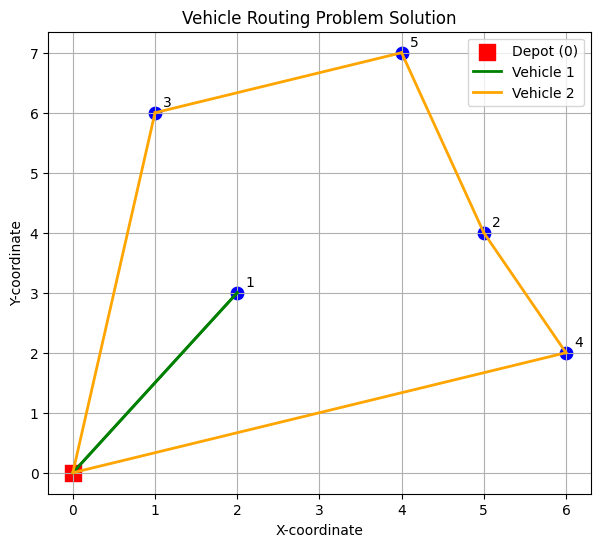

In [4]:
"""
A small Vehicle Routing Problem (VRP) solved with PuLP, with matplotlib visualization.
- Depot = node 0
- Customers = nodes 1..n
- Multiple vehicles K (here 2)
- Objective: minimize total distance
- MTZ subtour elimination constraints included

Dependencies:
    pip install pulp matplotlib
"""

import math
import pulp
import matplotlib.pyplot as plt
import itertools

# ---------------------------
# Data (same as Word doc)
# ---------------------------
locations = {
    0: (0, 0),  # depot
    1: (2, 3),
    2: (5, 4),
    3: (1, 6),
    4: (6, 2),
    5: (4, 7)
}

customers = [i for i in locations.keys() if i != 0]
nodes = list(locations.keys())
n = len(customers)
K = 2  # number of vehicles

# compute Euclidean distance matrix (rounded)
def euclid(a, b):
    return math.hypot(a[0] - b[0], a[1] - b[1])

c = {}
for i in nodes:
    c[i] = {}
    for j in nodes:
        if i == j:
            c[i][j] = 0
        else:
            c[i][j] = round(euclid(locations[i], locations[j]), 3)

# ---------------------------
# Build the PuLP model
# ---------------------------
prob = pulp.LpProblem("VRP_MTZ", pulp.LpMinimize)

# binary decision variables
x = {}
for i in nodes:
    for j in nodes:
        if i != j:
            x[(i, j)] = pulp.LpVariable(f"x_{i}_{j}", cat="Binary")

# MTZ variables
u = {}
for i in customers:
    u[i] = pulp.LpVariable(f"u_{i}", lowBound=1, upBound=n, cat="Integer")

# Objective
prob += pulp.lpSum(c[i][j] * x[(i, j)] for i in nodes for j in nodes if i != j), "TotalDistance"

# Constraints
for j in customers:
    prob += pulp.lpSum(x[(i, j)] for i in nodes if i != j) == 1
for i in customers:
    prob += pulp.lpSum(x[(i, j)] for j in nodes if j != i) == 1
prob += pulp.lpSum(x[(0, j)] for j in nodes if j != 0) == K
prob += pulp.lpSum(x[(i, 0)] for i in nodes if i != 0) == K

for i in customers:
    for j in customers:
        if i != j:
            prob += u[i] - u[j] + (n * x[(i, j)]) <= n - 1

# ---------------------------
# Solve
# ---------------------------
solver = pulp.PULP_CBC_CMD(msg=True, timeLimit=60)
prob.solve(solver)

status = pulp.LpStatus[prob.status]
print("Status:", status)
print("Total distance (objective):", pulp.value(prob.objective))

# Extract solution arcs
selected_arcs = [(i, j) for (i, j), var in x.items() if var.value() == 1]
print("Selected arcs:", selected_arcs)

# Build routes
routes = []
unused_arcs = selected_arcs.copy()
for vehicle in range(K):
    route = [0]
    current = 0
    while True:
        next_nodes = [j for (i, j) in unused_arcs if i == current]
        if not next_nodes:
            break
        next_node = next_nodes[0]
        route.append(next_node)
        unused_arcs.remove((current, next_node))
        current = next_node
        if current == 0:
            break
    routes.append(route)

print("\nRoutes found:")
for idx, r in enumerate(routes, 1):
    print(f" Vehicle {idx}: {r}")

# ---------------------------
# Visualization
# ---------------------------
plt.figure(figsize=(7, 6))

# Plot depot
plt.scatter(*locations[0], c="red", marker="s", s=120, label="Depot (0)")

# Plot customers
for i in customers:
    plt.scatter(*locations[i], c="blue", s=80)
    plt.text(locations[i][0] + 0.1, locations[i][1] + 0.1, str(i), fontsize=10)

# Colors for vehicles
colors = itertools.cycle(["green", "orange", "purple", "brown", "cyan"])

for idx, route in enumerate(routes, 1):
    color = next(colors)
    for i in range(len(route) - 1):
        start, end = route[i], route[i + 1]
        x_coords = [locations[start][0], locations[end][0]]
        y_coords = [locations[start][1], locations[end][1]]
        plt.plot(x_coords, y_coords, color=color, linewidth=2, label=f"Vehicle {idx}" if i == 0 else "")

plt.title("Vehicle Routing Problem Solution")
plt.legend()
plt.grid(True)
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.show()
